Red channel:
tensor([[0.0000],
        [0.9294]])
Green channel:
tensor([[0.0000],
        [0.1098]])
Blue channel:
tensor([[0.0000],
        [0.1412]])
Alpha channel:
tensor([[0.],
        [1.]])


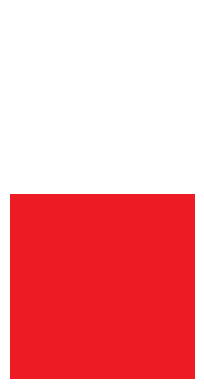

In [10]:
import cv2
import numpy as np
import os

from PIL import Image


def get_object_bounding_boxes(image):
    # アルファチャンネルを取得し、バイナリマスクを作成
    alpha_channel = image[:, :, 3]

    # cv2.threshold関数を使用して、アルファチャンネルの値が1以上のピクセルを255（白）に、それ以外を0（黒）に変換します。
    # これにより、画像のオブジェクト部分を白、背景部分を黒としたバイナリマスクが作成されます。
    _, binary_mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)

    # 輪郭を検出
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours or []


def show_bounding_boxes(image_path):
    # 透明背景の画像をRGBA形式で読み込む
    image_pil = Image.open(image_path)

    # PIL画像をOpenCV形式に変換
    image = np.array(image_pil)

    # バウンディングボックスの取得
    contours = get_object_bounding_boxes(image)
    rects = [cv2.boundingRect(c) for c in contours]

    # バウンディングボックスの描画
    image_bgr = cv2.cvtColor(image[:, :, :3], cv2.COLOR_RGB2BGR)
    [
        cv2.rectangle(image_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
        for [x,y,w,h] in rects
    ]

    # バウンディングボックスを適用した画像の表示
    cv2.imshow('Bounding Box', image_bgr)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


show_bounding_boxes('../data/nobg/ポケットモンスターシールド/2020022922273500_s.png')


In [9]:
import os

input_dir = "../data/nobg/ポケモン公式"
output_dir = "../data/cropped/ポケモン公式"

def get_max_bounding_rect(contours):
    if len(contours) == 0:
        return 0,0,0,0

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return x, y, w, h

# Loop over all files and subdirectories in the input directory
for root, dirs, files in os.walk(input_dir):
    for filename in files:
        # Construct full file path
        file_path = os.path.join(root, filename)
        
        # Open the image and convert it to numpy array
        image_pil = Image.open(file_path)
        image = np.array(image_pil)
        
        # Get the bounding boxes of the objects in the image
        contours = get_object_bounding_boxes(image)
        
        if len(contours) == 0:
            continue
        
        # Get the maximum bounding rectangle
        x, y, w, h = get_max_bounding_rect(contours)
        
        # Crop the image
        cropped_image = image[y:y+h, x:x+w]
        
        cropped_image_pil = Image.fromarray(cropped_image)
        
        # Create output subdirectory if it doesn't exist
        output_subdir = os.path.join(output_dir, os.path.relpath(root, input_dir))
        os.makedirs(output_subdir, exist_ok=True)
        
        # Save the cropped image to the output directory
        output_file_path = os.path.join(output_subdir, filename)
        cropped_image_pil.save(output_file_path)
